In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

warnings.simplefilter('ignore')
np.random.seed(3127)

# Spotify Genres - Data Mining
## Authors
*Konrad Szewczyk (145466)*  
*Jerzy Łukaszewicz (145458)*  
*Marek Szydłowski (136633)*
## Business objective
Maintaining radio stations or constructing playlists of high quality can be an expensive and daunting task. People enjoying these forms of listening to music may expect that songs offered by any particular source should be as similar to each other as possible - combining somber and lively pieces steer the audience towards the other providers.  
Therefore, it is crucial to find a number of sets/clusters of music tracks that could be viably combined together into a single playlist or radio station. The number of presented options should not be too high (maintaining many stations/playlists is not profitable) and tracks/songs should obviously be relatively similar to others composing the same cluster.
## Dataset
The dataset we are using for this task can be found on kaggle (https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks) and comprises data obtained using Spotify API. Although a variety of data can be found in this dataset, we will mostly limit ourselves to one of the files: data_o.csv (data regarding particular tracks), with every song being described with parameters portraying musical properties like:
* acousticness (0-1)
* danceability (0-1)
* energy (0-1)
* duration (usually between 200k and 300k in miliseconds)
* instrumentalness (0-1)
* valence (0-1)
* tempo (50-150)
* liveness (0-1)
* loudness (-60-0)
* speechiness (0-1)
* mode (0=minor, 1=major)
* key (categorical, 0-11).  

In [2]:
tracks_df = pd.read_csv('data/data_o.csv')

In [3]:
tracks_df = tracks_df.sort_values(by='popularity', ascending=False, ignore_index = True)

In [4]:
tracks_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.145,2020,0.4010,"['Bad Bunny', 'Jhay Cortez']",0.731,205090,0.573,1,47EiUVwUp4C9fGccaPuUCS,0.000052,4,0.1130,-10.059,0,Dakiti,100,2020-10-30,0.0544,109.928
1,0.756,2020,0.2210,"['24kGoldn', 'iann dior']",0.700,140526,0.722,1,3tjFYV6RSFtuktYl3ZtYcq,0.000000,7,0.2720,-3.558,0,Mood (feat. iann dior),99,2020-07-24,0.0369,90.989
2,0.737,2020,0.0112,['BTS'],0.746,199054,0.765,0,0t1kP63rueHleOhQkYSXFY,0.000000,6,0.0936,-4.410,0,Dynamite,97,2020-08-28,0.0993,114.044
3,0.357,2020,0.0194,"['Cardi B', 'Megan Thee Stallion']",0.935,187541,0.454,1,4Oun2ylbjFKMPTiaSbbCih,0.000000,1,0.0824,-7.509,1,WAP (feat. Megan Thee Stallion),96,2020-08-07,0.3750,133.073
4,0.682,2020,0.4680,['Ariana Grande'],0.737,172325,0.802,1,35mvY5S1H3J2QZyna3TFe0,0.000000,0,0.0931,-4.771,1,positions,96,2020-10-30,0.0878,144.015


The dataset contains over 170k tracks; however, most of them are obscure and unknown. In order to provide a meaningful set of static playlists, it makes sense to limit ourself to a subset of the most popular songs.

In [5]:
tracks_df.quantile([0, .05, .25, .5, .75, .95, 1])

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
0.00,0.0000,1921.0,0.00000,0.000,5108.0,0.000,0.0,0.000000,0.0,0.0000,-60.0000,0.0,0.0,0.0000,0.0000
0.05,0.0905,1933.0,0.00147,0.230,110987.0,0.076,0.0,0.000000,0.0,0.0599,-22.0200,0.0,0.0,0.0281,74.1516
0.25,0.3170,1956.0,0.10200,0.415,169827.0,0.255,0.0,0.000000,2.0,0.0988,-14.6150,0.0,11.0,0.0349,93.4210
0.50,0.5400,1977.0,0.51600,0.548,207467.0,0.471,0.0,0.000216,5.0,0.1360,-10.5800,1.0,33.0,0.0450,114.7290
0.75,0.7470,1999.0,0.89300,0.668,262400.0,0.703,0.0,0.102000,8.0,0.2610,-7.1830,1.0,48.0,0.0756,135.5370
0.95,0.9370,2016.0,0.99200,0.811,411551.6,0.924,1.0,0.905000,11.0,0.6100,-4.1306,1.0,66.0,0.3540,174.3738
1.00,1.0000,2020.0,0.99600,0.988,5403500.0,1.000,1.0,1.000000,11.0,1.0000,3.8550,1.0,100.0,0.9700,243.5070


## Preprocessing
There are no missing values in our dataset regarding Spotify tracks, hence we do not need to impute any values. However, that does not mean there is nothing we should take care of before applying clusterisation algorithm.

### Feature selection
The data being clustered should be free of any IDs or any attributes that would be able to distract the algorithm from "real" distinguishing factors. Therefore, the first action we take is removing the id/name/year/artist attributes.

In [6]:
tracks_popular = tracks_df.iloc[:30000]
tracks_stand = tracks_df.drop(['id', 'name', 'release_date', 'year', 'artists', 'popularity'], axis=1)

### Standardisation
Since both outlier removal and clustering algorithm used by us are based on distance metrics, we need to standardise the values of numerical attributes in order to ensure equal impact of all attributes beforehand and after any operation that may "de-standardise" the data.

In [7]:
scaler = preprocessing.StandardScaler()

tracks_stand = pd.DataFrame(
    scaler.fit_transform(tracks_stand),
    index=tracks_stand.index,
    columns=tracks_stand.columns
)

popular_stand = pd.DataFrame(
    scaler.fit_transform(tracks_stand.iloc[:30000]),
    index=tracks_stand.iloc[:30000].index,
    columns=tracks_stand.columns
)

Data following standardisation:

In [8]:
popular_stand

,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
0,-1.454292,0.429120,0.775046,-0.314337,-0.208844,1.90067,-0.309359,-0.344638,-0.475585,-0.460421,-1.401162,-0.357623,-0.352387
1,0.987495,-0.186113,0.592047,-1.155162,0.458276,1.90067,-0.309617,0.498616,0.585857,0.962966,-1.401162,-0.538711,-0.977910
2,0.911563,-0.903202,0.863594,-0.392945,0.650801,-0.52613,-0.309617,0.217531,-0.605094,0.776422,-1.401162,0.106998,-0.216442
3,-0.607060,-0.875175,1.979300,-0.542880,-0.741645,1.90067,-0.309617,-1.187892,-0.679862,0.097899,0.713693,2.959915,0.412053
4,0.691763,0.658124,0.810465,-0.741040,0.816461,1.90067,-0.309617,-1.468977,-0.608432,0.697381,0.713693,-0.012003,0.773448
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-1.010694,-0.312578,0.355918,-0.280777,-0.123775,-0.52613,-0.309525,1.060786,-0.549018,0.600168,-1.401162,-0.641156,-1.140409
29996,0.248165,2.370524,0.438563,-0.860227,-1.064012,-0.52613,-0.208684,-0.906807,-0.295340,-0.949114,0.713693,-0.548024,-0.273912
29997,-0.531129,1.310955,-0.683046,-0.915093,-0.961034,-0.52613,-0.309617,0.498616,-0.633799,-0.685938,0.713693,-0.589416,0.923265
29998,-0.770911,-0.683769,1.589689,1.448862,0.028454,1.90067,-0.309617,1.622955,-0.711906,0.684025,0.713693,0.383287,0.346062


Quantiles of standardised data:

In [9]:
popular_stand.quantile([0, .05, .25, .5, .75, .95, 1])

,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
0.00,-2.033766,-0.941483,-3.540198,-2.587014,-2.774258,-0.52613,-0.309617,-1.468977,-1.229943,-10.264512,-1.401162,-0.920549,-3.983121
0.05,-1.602158,-0.938995,-1.781043,-1.155939,-1.883361,-0.52613,-0.309617,-1.468977,-0.844085,-1.725365,-1.401162,-0.634947,-1.423395
0.25,-0.786897,-0.839628,-0.629917,-0.519272,-0.643144,-0.52613,-0.309617,-0.906807,-0.600421,-0.340053,-1.401162,-0.563546,-0.793166
0.50,-0.015596,-0.401445,0.066661,-0.106879,0.113523,-0.52613,-0.309596,-0.063553,-0.402151,0.239121,0.713693,-0.429023,-0.021526
0.75,0.803661,0.634198,0.733724,0.368634,0.785120,-0.52613,-0.304699,0.779701,0.298801,0.624964,0.713693,0.046980,0.641674
0.95,1.646897,2.103922,1.507044,1.413278,1.425377,1.90067,2.960830,1.622955,2.007789,1.035438,0.713693,2.318863,1.780856
1.00,1.934636,2.462809,2.292170,50.673333,1.702970,1.90067,4.638109,1.622955,5.419090,2.035815,0.713693,8.847874,3.286373


### Outlier removal
Outliers can lead to abnormal behaviour of ML and DM algorithms; therefore, we use Local Outlier Factor-based outlier detection algorithm to get rid of them.  
Local Outlier Factor measures the local deviation of density of a given sample with respect to its neighbours and in this way is able to determine how isolated any given sample is.

In [10]:
convert = lambda val: True if val == -1 else False

In [11]:
clf = LocalOutlierFactor(n_jobs=-1)

outliers = clf.fit_predict(popular_stand.select_dtypes(exclude=object))
outliers = [convert(val) for val in outliers]

print(f"Detected {sum(outliers)} outliers ({round(sum(outliers) / len(popular_stand) * 100, 2)}%)")

Detected 187 outliers (0.62%)


In [12]:
popular_stand.drop(popular_stand[outliers].index, inplace=True)

In [13]:
scaler = preprocessing.StandardScaler()

popular_stand = pd.DataFrame(
    scaler.fit_transform(popular_stand),
    index=popular_stand.index,
    columns=popular_stand.columns
)

Data following Outlier Removal and standardisation:

In [14]:
popular_stand.head(5)

,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
0,-1.464251,0.434836,0.774489,-0.361418,-0.213412,1.900193,-0.304748,-0.344686,-0.474724,-0.486443,-1.401677,-0.357464,-0.357422
1,0.986103,-0.182634,0.589854,-1.351256,0.457074,1.900193,-0.305009,0.499441,0.591935,0.980925,-1.401677,-0.539907,-0.987810
2,0.909906,-0.902330,0.863828,-0.453957,0.650570,-0.526262,-0.305009,0.218065,-0.604870,0.788616,-1.401677,0.110633,-0.220420
3,-0.614046,-0.874201,1.989502,-0.630464,-0.748901,1.900193,-0.305009,-1.188813,-0.680006,0.089128,0.713431,2.984893,0.412964
4,0.689334,0.664673,0.810224,-0.863742,0.817067,1.900193,-0.305009,-1.470188,-0.608225,0.707134,0.713431,-0.009258,0.777170


### Dimensionality reduction 
Distance-based methods many encounted negative impact of phenomena called the "curse of dimensionality" that occurs when a distance between two objects is calculated in an multi-dimensional environment is calculated. Dimensionality reduction algorithms, such as PCA, can be therefore used to reduce the number of dimensions and ensure correct representation of distances.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


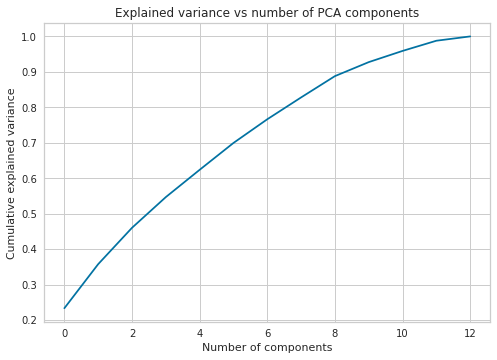

In [15]:
pca = PCA().fit(popular_stand)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained variance vs number of PCA components")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [16]:
pca = PCA(n_components=8)

Data after mapping it using 8 PCA components:

In [17]:
tracks_pca = pd.DataFrame(
    pca.fit_transform(popular_stand),
    index=popular_stand.index,
    columns=['PCA_{}'.format(i) for i in range(8)]
)

tracks_pca.head(5)

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
0,0.278460,1.855064,0.719560,0.409059,-0.077108,0.866782,0.297003,-1.336122
1,-1.694874,1.287312,-0.248167,0.946499,0.892948,-0.876597,0.225151,-1.259284
2,-1.662148,-0.046207,-0.715231,1.265405,0.154577,0.134244,0.955327,-0.556029
3,-1.458801,3.418890,0.320703,-1.819108,-0.542795,1.064744,0.248062,0.601677
4,-1.320683,1.079881,-0.837004,-1.757726,-0.568912,0.443914,0.625821,-0.063106


Data after mapping it using 8 PCA components after standardisation:

In [18]:
tracks_pca = pd.DataFrame(
    scaler.fit_transform(tracks_pca),
    index=tracks_pca.index,
    columns=tracks_pca.columns
).reset_index(drop=True)

tracks_pca.head(5)

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
0,0.159896,1.459296,0.623282,0.385469,-0.077095,0.873417,0.318645,-1.493040
1,-0.973220,1.012671,-0.214962,0.891915,0.892796,-0.883307,0.241558,-1.407178
2,-0.954429,-0.036349,-0.619532,1.192430,0.154551,0.135272,1.024940,-0.621331
3,-0.837664,2.689488,0.277793,-1.714202,-0.542702,1.072894,0.266138,0.672340
4,-0.758355,0.849494,-0.725012,-1.656360,-0.568816,0.447312,0.671424,-0.070517


Created columns by PCA are really hard to interpret as each column is a linear combinations of all atributes. So for example the first column "PCA_0" (presented above) consists of given combinations.

In [19]:
for ind, comp in enumerate(pca.components_):
    text = f"PCA_{ind} = (\n"
    for i, val in enumerate(comp):
        if i != len(comp) - 1:
            text += f"\t{val:<21} * {popular_stand.columns[i]} + \n"
        else:
            text += f"\t{val:<21} * {popular_stand.columns[i]}\n)"
    print(text)     
    break 
print("...")

PCA_0 = (
	-0.293060370798222    * valence + 
	0.4169733330724702    * acousticness + 
	-0.29474014813012533  * danceability + 
	0.047999239877994065  * duration_ms + 
	-0.4606658681716673   * energy + 
	-0.1960872408632477   * explicit + 
	0.31477925150750274   * instrumentalness + 
	-0.04228348543585699  * key + 
	-0.07777812689737809  * liveness + 
	-0.4767374902783681   * loudness + 
	0.08560864918451135   * mode + 
	-0.2008353905652639   * speechiness + 
	-0.13617742690395962  * tempo
)
...


In [20]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=8888).fit(tracks_pca)

tracks_pca['cluster'] = kmeans.labels_
groups = tracks_pca.iloc[popular_stand.reset_index(drop=True).iloc[:2000].index.values].groupby('cluster')

As we can see on the graph below, the data has been clustered into (k=5) clusters but they are densely packed. One reason for this clustering could be that music is a really subjective topic as are music genres and the boundaries between each song may or may not be so clear, thus it's really hard to get any meaningful, fully seperable clusters. 

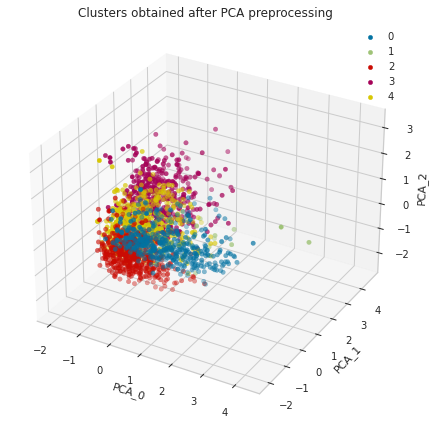

In [22]:
fig = plt.figure() 
ax = Axes3D(fig) 

for name, group in groups:     
    ax.scatter(
        group['PCA_0'].values, 
        group['PCA_1'].values, 
        group['PCA_2'].values, 
        marker="o", label=name
    )

ax.legend()
ax.set_xlabel("PCA_0") 
ax.set_ylabel("PCA_1") 
ax.set_zlabel("PCA_2") 
plt.title("Clusters obtained after PCA preprocessing")
plt.show()

## Clustering algorithm
For this clusterisation task, we have decided to use kMeans algorithm, which works by creating and recalculating centroids as long as any sample shifts its cluster. It needs to be initialised for a specific number of clusters (parameter k) that must be found experimentally.  
### Parameter tuning (number of clusters)
In order to establish a good number of clusters for our data, we use heuristic method called "elbow method" that involves finding an elbow of the curve of a measurement (in our case - sum of squared distances of sample to their cluster's centroid) as the number of clusters increases. 


In [23]:
scores = []

for n_clusters in range(1, 20):
    clustering = KMeans(n_clusters = n_clusters, random_state=2500)
    clustering.fit(popular_stand)

    scores.append(clustering.inertia_)

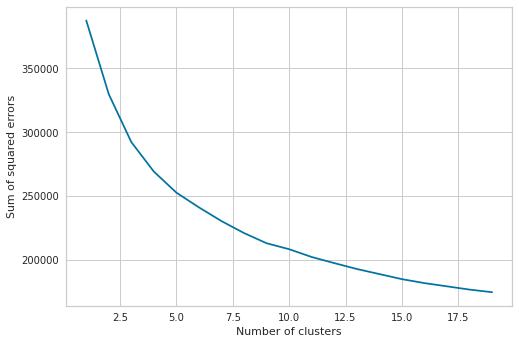

In [24]:
sn.lineplot(x = range(1, 20), y = scores)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared errors")
plt.show()

The curve has no clearly defined elbow, which makes it difficult to select an optimal value of parameter k. Moreover, we do not know whether our data actually has any meaninful clusters. We can check it using Silhouette score - a measure of consistency of data within clusters that compares how similar an object is to its own vs other clusters. Consistently low values of that measure may suggest that the data has no natural division into clusters.

In [25]:
scores = []

for n_clusters in range(2, 10):
    clustering = KMeans(n_clusters = n_clusters, random_state=2500)
    clustering.fit(popular_stand)

    scores.append(silhouette_score(popular_stand, clustering.labels_))

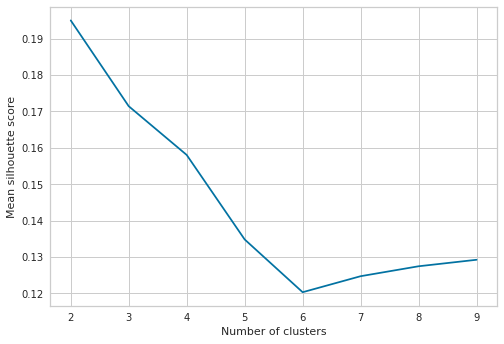

In [26]:
sn.lineplot(x = range(2, 10), y = scores)
plt.xlabel("Number of clusters")
plt.ylabel("Mean silhouette score")
plt.show()

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, random_state=2500))

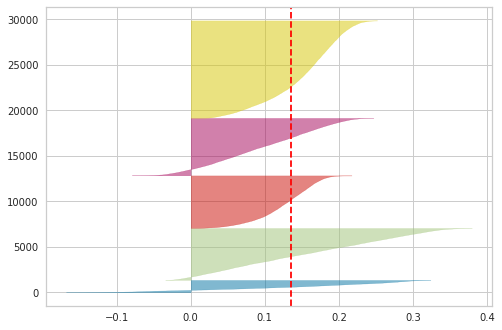

In [27]:
clustering = KMeans(n_clusters = 5, random_state=2500)
clustering.fit(popular_stand)
clusters = clustering.labels_

visualiser = SilhouetteVisualizer(clustering, colors='yellowbrick')
visualiser.fit(popular_stand)

Obtained values of Silhouette score are low for all proposed numbers of clusters, which leads us to conclusions that in fact there are no naturally-occuring clusters in our data. Therefore, it is impossible to distinguish any objectively valid "hyper-genres" of music. 
### Proposed clustering
Despite the lack of genuine clusters in our data, we may still need to generate static playlists of song. Fortunatelly, kMeans is able to generate some clusters that, although do not represent fully separate groups, can be used to propose relatively similar songs for playlists or radio stations.

In [28]:
n_clusters = 5

clustering = KMeans(n_clusters = n_clusters, random_state=2500)
clustering.fit(popular_stand)

tracks_clusters = tracks_popular.join(popular_stand, how='right', rsuffix='_std')
tracks_clusters['cluster'] = clustering.labels_

tracks_clusters.head(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,energy_std,explicit_std,instrumentalness_std,key_std,liveness_std,loudness_std,mode_std,speechiness_std,tempo_std,cluster
0,0.145,2020,0.4010,"['Bad Bunny', 'Jhay Cortez']",0.731,205090,0.573,1,47EiUVwUp4C9fGccaPuUCS,0.000052,...,-0.213412,1.900193,-0.304748,-0.344686,-0.474724,-0.486443,-1.401677,-0.357464,-0.357422,3
1,0.756,2020,0.2210,"['24kGoldn', 'iann dior']",0.700,140526,0.722,1,3tjFYV6RSFtuktYl3ZtYcq,0.000000,...,0.457074,1.900193,-0.305009,0.499441,0.591935,0.980925,-1.401677,-0.539907,-0.987810,3
2,0.737,2020,0.0112,['BTS'],0.746,199054,0.765,0,0t1kP63rueHleOhQkYSXFY,0.000000,...,0.650570,-0.526262,-0.305009,0.218065,-0.604870,0.788616,-1.401677,0.110633,-0.220420,2
3,0.357,2020,0.0194,"['Cardi B', 'Megan Thee Stallion']",0.935,187541,0.454,1,4Oun2ylbjFKMPTiaSbbCih,0.000000,...,-0.748901,1.900193,-0.305009,-1.188813,-0.680006,0.089128,0.713431,2.984893,0.412964,3
4,0.682,2020,0.4680,['Ariana Grande'],0.737,172325,0.802,1,35mvY5S1H3J2QZyna3TFe0,0.000000,...,0.817067,1.900193,-0.305009,-1.470188,-0.608225,0.707134,0.713431,-0.009258,0.777170,3


In [29]:
cluster_dict = {'cluster': [], 'prop': [], 'value': []}
musical_props = ['valence', 'danceability', 'instrumentalness', 'speechiness', 'energy']

for i in range(n_clusters):
    print("Cluster {}:".format(i))

    for prop in musical_props:
        value = np.mean(tracks_clusters[tracks_clusters['cluster'] == i][prop])
        cluster_dict['cluster'].append(i)
        cluster_dict['prop'].append(prop)
        cluster_dict['value'].append(value)
        print("\t{0}: {1}".format(prop, value))
    print()

cluster_data = pd.DataFrame(data=cluster_dict)

Cluster 0:
	valence: 0.20467857355126298
	danceability: 0.3656337295690936
	instrumentalness: 0.8295213248142644
	speechiness: 0.050622734026745914
	energy: 0.28618904338781576

Cluster 1:
	valence: 0.3702941347841348
	danceability: 0.526085608985609
	instrumentalness: 0.019301320305370306
	speechiness: 0.047507037557037564
	energy: 0.35267300280800284

Cluster 2:
	valence: 0.5791488985255855
	danceability: 0.617879323503903
	instrumentalness: 0.036974592926279276
	speechiness: 0.07401913269731136
	energy: 0.7267108412836079

Cluster 3:
	valence: 0.483910450364732
	danceability: 0.7055033301617508
	instrumentalness: 0.007748008095464635
	speechiness: 0.19481555661274974
	energy: 0.655256739613067

Cluster 4:
	valence: 0.6012567956627406
	danceability: 0.5997173677322863
	instrumentalness: 0.03085848169751355
	speechiness: 0.06075864647597683
	energy: 0.7272836044120395



## Proposed clusters/playlists


In [30]:
def propose_playlist(tracks_clusters, playlist_no):
    print("Example popular songs:")
    for index, row in tracks_clusters[tracks_clusters['cluster'] == playlist_no].iloc[:5].iterrows():
        print('\t"{0}" by {1}'.format(row['name'], row['artists']))

The following graph presents core audio parameters of clusters proposed by kMeans algorithm with k = 5. We have decided to show only the most descriptive parameters, although there may exist more differences in terms of e.g. tempo or duration.

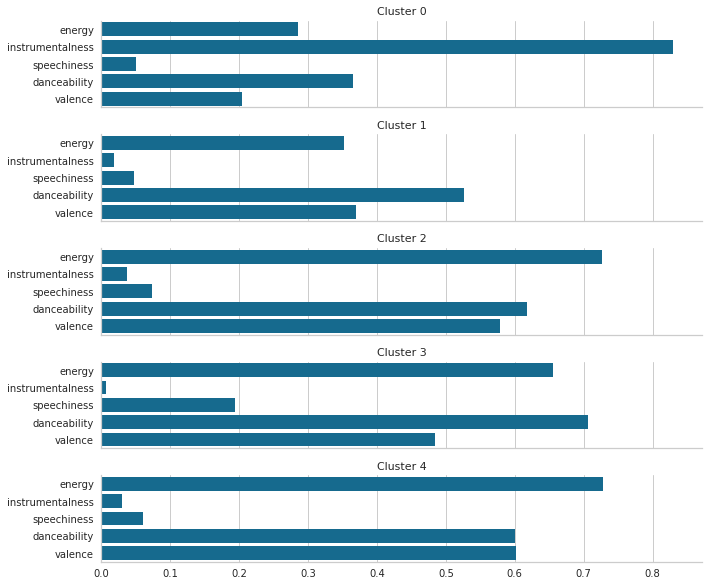

In [31]:
    fig = sn.FacetGrid(cluster_data, row="cluster", height = 1.7, aspect = 6)
    fig.map(sn.barplot, 'value', 'prop', order = ['energy', 'instrumentalness', 'speechiness', 'danceability', 'valence'])
    fig.set(xlabel=None)
    fig.set(ylabel=None)
    fig.set_titles(row_template='Cluster {row_name}')

### Cluster 0 (low energy + high instrumentalness)
The first proposed cluster consists of slow tracks with little vocal. They are also characterised by low valence and medium danceability.

In [32]:
propose_playlist(tracks_clusters, 0)

Example popular songs:
	"everything i wanted" by ['Billie Eilish']
	"Buttercup" by ['Jack Stauber']
	"White Noise - 500 hz" by ['Granular']
	"Eternal Youth" by ['RŮDE']
	"Ribs" by ['Lorde']


### Cluster 1 (low energy + low instrumentalness)
The second proposed cluster consists of slow tracks with higher frequency of vocal parts. They are also slightly more danceable.

In [33]:
propose_playlist(tracks_clusters, 1)

Example popular songs:
	"Lonely (with benny blanco)" by ['Justin Bieber', 'benny blanco']
	"you broke me first" by ['Tate McRae']
	"Heather" by ['Conan Gray']
	"Someone You Loved" by ['Lewis Capaldi']
	"Memories" by ['Maroon 5']


### Cluster 2 (high energy + high danceability)
This cluster is composed of songs that are energetic, lively and inviting to physical activities such as dancing. These song should encourage positive mood in the audience.

In [34]:
propose_playlist(tracks_clusters, 2)

Example popular songs:
	"Dynamite" by ['BTS']
	"Put Your Records On" by ['Ritt Momney']
	"Therefore I Am" by ['Billie Eilish']
	"Wonder" by ['Shawn Mendes']
	"Breaking Me" by ['Topic', 'A7S']


### Cluster 3 (high energy + medium danceability + mediocre speechiness)
These songs are slightly less energetic and danceable compared to the previous cluster, but they may consist of more spoken or rapped parts. Lower valence may also suggest they are less upbeat.

In [35]:
propose_playlist(tracks_clusters, 3)

Example popular songs:
	"Dakiti" by ['Bad Bunny', 'Jhay Cortez']
	"Mood (feat. iann dior)" by ['24kGoldn', 'iann dior']
	"WAP (feat. Megan Thee Stallion)" by ['Cardi B', 'Megan Thee Stallion']
	"positions" by ['Ariana Grande']
	"What You Know Bout Love" by ['Pop Smoke']


### Cluster 4 (high energy + high danceability)
Similarly to songs in the Cluster 3, these songs are upbeat and should invoke positive emotions. They are also highly danceability and energetic.

In [36]:
propose_playlist(tracks_clusters, 4)

Example popular songs:
	"Blinding Lights" by ['The Weeknd']
	"Watermelon Sugar" by ['Harry Styles']
	"Head & Heart (feat. MNEK)" by ['Joel Corry', 'MNEK']
	"Relación - Remix" by ['Sech', 'Daddy Yankee', 'J Balvin', 'ROSALÍA', 'Farruko']
	"Vida de Rico" by ['Camilo']


## Conclusion
Although we have concluded that there are no natural clusters in the dataset of Spotify tracks, we were able to propose a number of reasonable playlists of popular songs that go "well" together and share some musical features.  
  
However, while statically generated playlists have their advantages, we may be able to propose something better suited for XXI century music industry.

### Alternative: kNN-generated recommendation playlists
The better solution for creating playlists may be to find similar songs based on one's taste of music, therfore we've presented very simple approach of finding top 5 most similar songs to a given one based on distance measures (5 nearest neighbours). It is really simple approach which can be improved greatly - one field of improvment could be giving more than one song to find more suitable songs, as one song can be too specific and returned playlist may not be accurate of user's taste in music. Of course it's only a prototype thus finding similar songs is a tedious process which require user to give all statistics about song (all its attributes) which is obviously not doable for normal user as he/she doesn't know them beforehand. Therefore we could easily implement HTTP request to get a song's attributes based on its id which is unique identifier of a given song. 

In [37]:
nbrs = NearestNeighbors(n_neighbors=5).fit(tracks_stand.drop(columns=['duration_ms', 'explicit', 'key', 'mode']))

In [38]:
dist, inds = nbrs.kneighbors(tracks_stand.drop(columns=['duration_ms', 'explicit', 'key', 'mode']).iloc[422].values.reshape(1, -1))

In [39]:
# 422  - The Beatles - Here comes the sun
# 793	- Aerosmith  - Dream On
# 5066 - Metallica  - Nothing Else Matters

As we can see for song: "Here Comes The Sun" by "The Beatles" we've got following results:

In [40]:
tracks_df.iloc[inds.flatten()]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
422,0.394,1969,0.0339,['The Beatles'],0.557,185733,0.540,0,6dGnYIeXmHdcikdzNNDMm2,0.002480,9,0.179,-10.484,1,Here Comes The Sun - Remastered 2009,82,1969-09-26,0.0347,129.171
49118,0.326,1992,0.0546,['The Tragically Hip'],0.552,267360,0.513,0,1ffzAzDFSOvEbWTbC7aPLw,0.000848,2,0.178,-11.254,1,Courage (For Hugh MacLennan),46,1992-10-06,0.0274,133.739
18038,0.372,1981,0.0548,['Journey'],0.570,300147,0.554,0,5IK2FtuC0qmHHam9sWFxUI,0.000000,9,0.139,-9.732,0,Who's Crying Now,59,1981,0.0288,122.135
83586,0.381,1990,0.1060,['Wilson Phillips'],0.574,245467,0.521,0,4HZwXBG83ayZsvPh4Oule4,0.000014,2,0.152,-10.738,1,A Reason To Believe,34,1990-01-01,0.0285,138.427
103017,0.429,1972,0.0126,['T. Rex'],0.560,260333,0.511,0,6UlOoWHEF5esnMSGjpAk13,0.000000,2,0.235,-9.682,1,Main Man,27,1972-07-21,0.0598,127.906


Once again, as music is a really subjective matter, following suggestions may or may not be accurate for everyone liking that specific song by the Beatles but overall we think that these are quite good suggestions. We can also see that the model returned **suprisingly** the same song. And it's quite expected as model has already seen this song and it is in fact a perfect match ;)